!pip install --upgrade pip matplotlib

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
path_all_tfrecord = "fp56.tfrecord"

# path_train_tfrecord = "fp56_train.tfrecord"
# path_test_tfrecord = "fp56_test.tfrecord"

In [3]:
dir_model = "vgg_cam/"
path_best = dir_model + "model-17-1.17-53.3%.hdf5"
path_best

'vgg_cam/model-17-1.17-53.3%.hdf5'

In [4]:
from fp_tensorflow import _parse_pair_56, _parse_single_56
from fp_tensorflow import create_pair_56_dataset, create_single_dataset
from fp_tensorflow import VGG16_convolutions
from fp_tensorflow import create_vgg_5y_model

all_dataset = create_pair_56_dataset(path_all_tfrecord, "floorplan", "year").batch(64)

model = create_vgg_5y_model()
model.load_weights(path_best)

# predict

In [5]:
predictions = model.predict(all_dataset, verbose=1)

    786/Unknown - 283s 360ms/step

In [6]:
predictions = np.argmax(predictions, 1)

In [7]:
predictions[:128]

array([6, 6, 7, 6, 4, 4, 3, 6, 4, 3, 3, 7, 4, 4, 6, 6, 4, 4, 4, 6, 4, 4,
       4, 6, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 6, 5, 6, 9, 6, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 3, 4, 7, 7,
       7, 4, 8, 8, 7, 7, 8, 7, 7, 7, 7, 7, 3, 3, 6, 6, 6, 7, 7, 7, 7, 7,
       7, 7, 8, 8, 4, 5, 7, 4, 7, 7, 6, 8, 7, 7, 7, 5, 4, 4, 4, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 6, 7, 6, 7, 4, 6, 4, 8, 7, 8, 6, 8])

In [8]:
all_year = create_single_dataset(path_all_tfrecord, "year")
year_true = np.fromiter((y.numpy() for y in all_year), int)
year_true.shape, year_true[:10]

((50252,), array([6, 6, 6, 6, 2, 2, 2, 2, 2, 2]))

In [9]:
all_id = create_single_dataset(path_all_tfrecord, "plan_id")
ids = [i.numpy().decode() for i in all_id]
ids[:10]

['8928_160',
 '8928_183',
 '8928_201A',
 '8928_204B',
 '960_35',
 '960_41',
 '960_45',
 '960_49F',
 '960_50S',
 '960_53']

In [10]:
df = pd.DataFrame(
    zip(ids, year_true, predictions), columns=["ID", "true", "prediction"],
)
df

,ID,true,prediction
0,8928_160,6,6
1,8928_183,6,6
2,8928_201A,6,7
3,8928_204B,6,6
4,960_35,2,4
...,...,...,...
50247,115454_21D,9,9
50248,115454_34E,9,9
50249,115454_36B,9,9
50250,115454_37A,9,9


In [11]:
df.to_csv("vgg_5y_prediction.csv")

In [12]:
crosstab = pd.crosstab(df.true, df.prediction)
crosstab[0] = 0
crosstab = crosstab.reindex(index=range(10), columns=range(10), fill_value=0)
crosstab

prediction,0,1,2,3,4,5,6,7,8,9
true,,,,,,,,,,
0,0,0,1,16,13,0,4,20,8,0
1,0,0,4,12,147,14,18,29,6,3
2,0,0,6,69,482,36,36,25,24,10
3,0,0,3,406,1261,168,122,55,94,60
4,0,0,0,97,3040,727,396,171,131,26
5,0,0,0,23,1989,2311,1548,373,191,25
6,0,0,0,9,766,863,3487,2924,668,87
7,0,0,0,1,155,74,940,8933,2072,151
8,0,0,0,1,12,3,71,1489,6819,1618


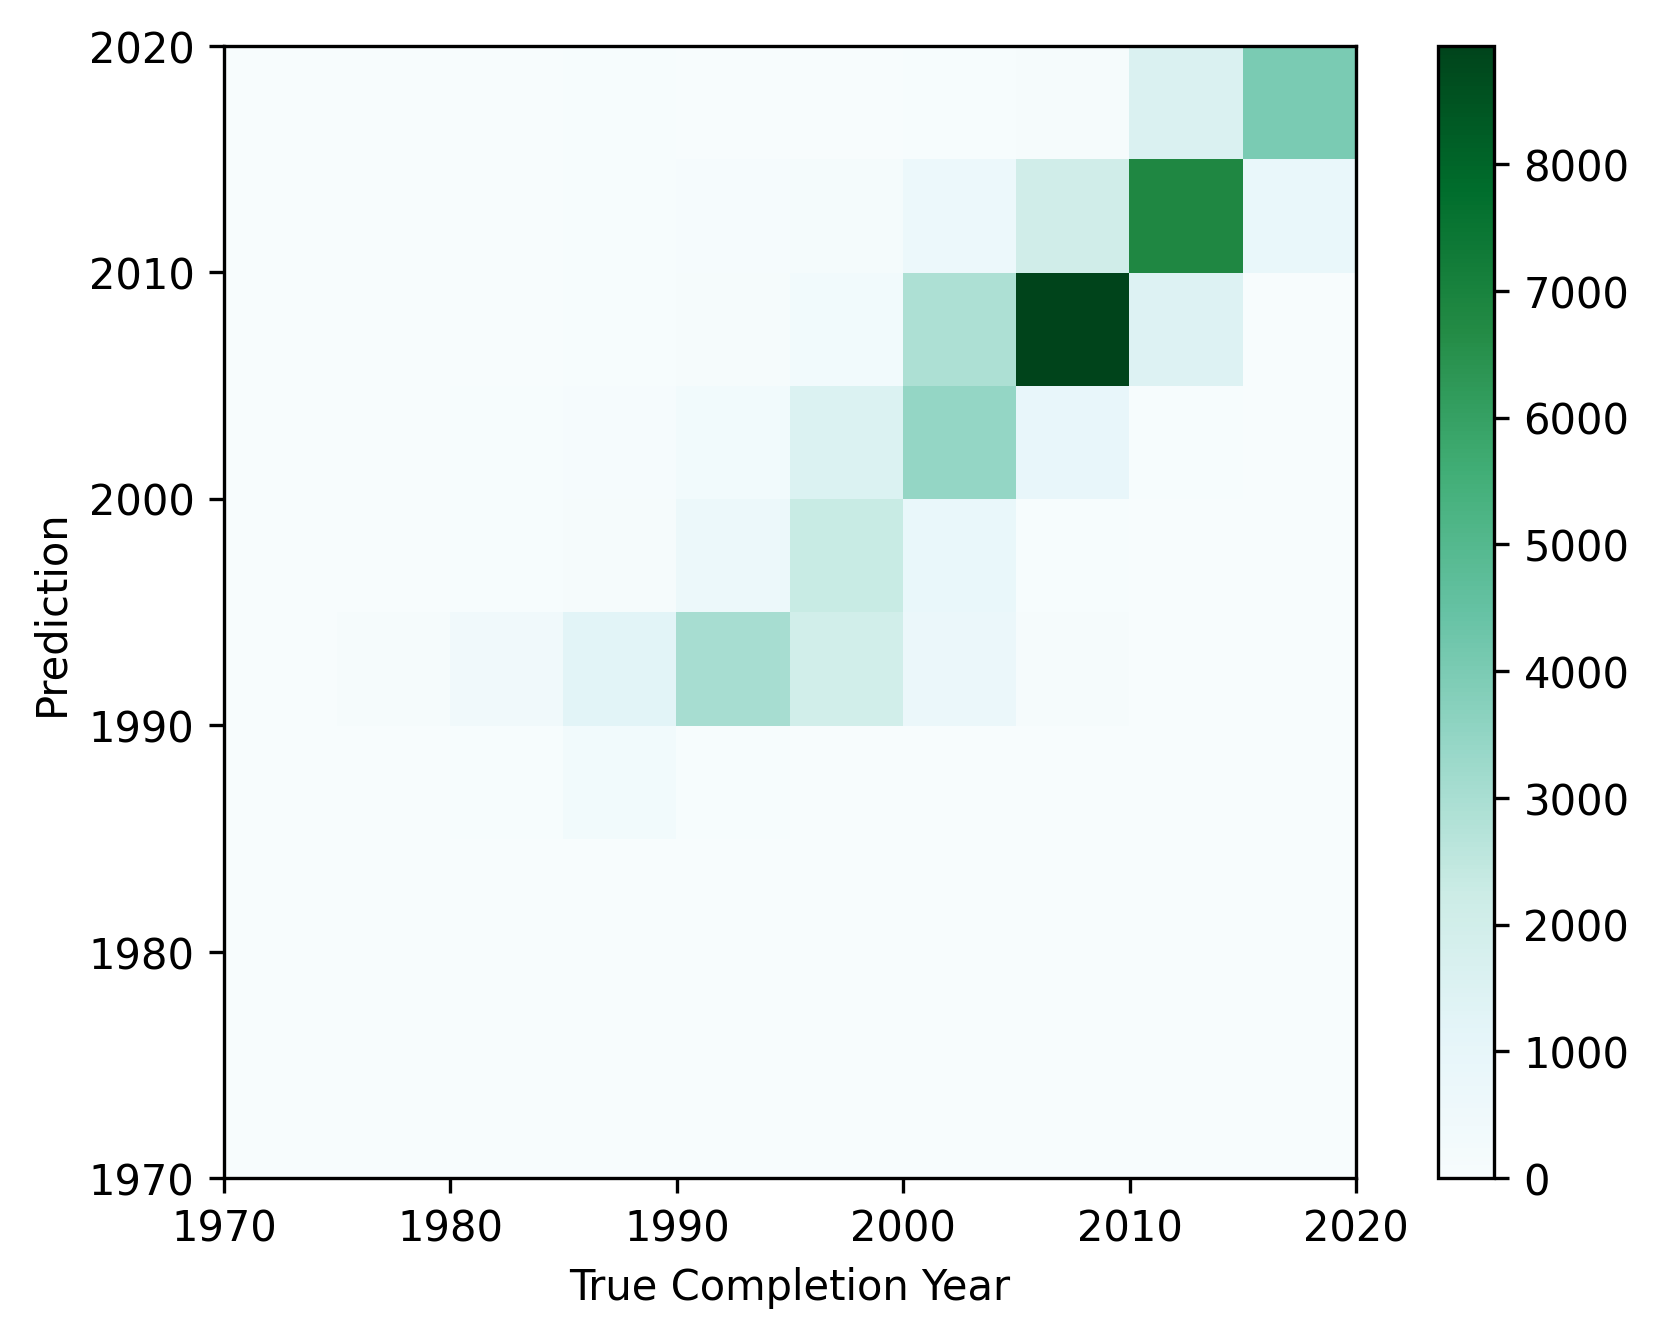

In [13]:
fig = plt.figure(figsize=(7, 5), dpi=300)
ax = fig.gca()

c = ax.pcolor(crosstab.transpose(), cmap="BuGn")

ax.set_aspect("equal")
ax.set_xlabel("True Completion Year")
ax.set_ylabel("Prediction")

ax.set_xticks(range(0, 11, 2))
ax.set_yticks(range(0, 11, 2))
ax.set_xticklabels(range(1970, 2021, 10))
ax.set_yticklabels(range(1970, 2021, 10))

fig.colorbar(c, ax=ax)

fig.savefig(
    "vgg_5y_heatmap.pdf", bbox_inches="tight", pad_inches=0,
)
fig.savefig(
    "vgg_5y_heatmap.png", bbox_inches="tight", pad_inches=0,
)

### 눈 먼 정확도는 딱 한 구간 틀린 게 많다는 걸 보여주지 못함...

In [14]:
correct = df[df.true == df.prediction].shape[0]
total = df.shape[0]
correct, total, f"{correct/total:.2%}"

(29027, 50252, '57.76%')

In [15]:
one_off = (
    df[df.true - 1 == df.prediction].shape[0]
    + df[df.true + 1 == df.prediction].shape[0]
)
one_off, f"{one_off/total:.2%}", f"{(correct+one_off)/total:.2%}"

(16457, '32.75%', '90.51%')